## Import packages

In [1]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import squareform, pdist, cdist
from numpy.linalg import slogdet
import scipy.optimize as opt
import time
import logging
import matplotlib.pyplot as plt
import mpl_scatter_density


## Base functions

In [2]:
#%%
def dist(locs, locs2=np.array([]), circular=False):
    locs = locs if np.ndim(locs)==2 else np.reshape(locs, [len(locs), 1])
    if circular:
        if len(locs2):
            xv, yv = np.meshgrid(locs, locs2)
        else:
            xv, yv = np.meshgrid(locs, locs)
        m = np.minimum(xv, yv)
        M = np.maximum(xv, yv)
        dist = np.matrix(np.minimum(M - m, m + 1-M).T)
    else:
        if len(locs2):
            dist = np.matrix(cdist(locs, locs2))
            # dist = cdist(locs, locs2)
        else:
            dist = np.matrix(squareform(pdist(locs)))
    return dist

def GetD(locs, locs2=np.array([]), l=1, circular=False):
    D = dist(locs, locs2, circular)
    return(D)


#%%
def directGPsimple2(X,y,phi=0.5,sigma=1):
    # version 2, add likelihood and sigma
    # GP4ML: http://gaussianprocess.org/gpml/chapters/RW.pdf
    
    locs = X
    
    # find only valid data, index
    obs = np.matrix(y)
    obs_inds = np.where(np.logical_not(np.isnan(obs)))[0]
    
    # knots
    knots = locs[obs_inds]
    kInds = obs_inds
    
    B = sigma**2 * np.exp(-phi * GetD(locs,knots)) # C(x,x*)
    K = B[kInds,:] # C(x,x)
    Kinv = np.linalg.inv(K) # C(x,x)^{-1}
    
    # posterior
    obsInds = np.array(np.isfinite(obs)).ravel() # True/False
    
    mean = B * np.matrix(Kinv) * obs[obsInds]
    var = sigma**2 * np.exp(-phi * GetD(locs,locs)) - B*Kinv*B.T
    
    
    # add likelihood
    sgn, logdetK = slogdet(K) # LU decomposition via LAPACK routine
    
    loglike1 = - obs[obsInds].T * Kinv * obs[obsInds]
    loglike2 = - sgn*logdetK
    
    loglike = loglike1[0,0] + loglike2
    
    return mean, var, loglike

## Generate simulation data

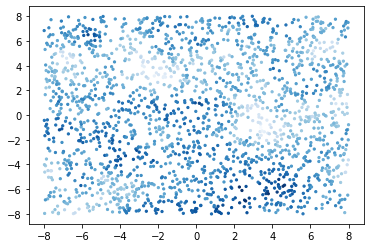

In [3]:
#%%
phi = 0.5
sigma = 1.1
NoS = 2000

n1a,n1b = -8,8
n2a,n2b = -8,8 

x1 = np.linspace(n1a,n1b,NoS)
x2 = np.linspace(n1a,n1b,NoS)

np.random.shuffle(x1)
np.random.shuffle(x2)

X = np.array([x1,x2]).T

cmatrix = sigma**2 * np.exp(-phi * GetD(X,X))
y = np.random.multivariate_normal(mean=np.zeros(NoS), cov=cmatrix)
y = y.reshape(-1,1)


fig = plt.figure()
plt.scatter(X[:,0],X[:,1],c=y,s=5,cmap='Blues')
plt.show()

## Optimization to get parameters

In [4]:
#%% true = [0.5,1.1]
np.random.seed(68)
params = {}
params['phi'] = 0.3
params['sigma'] = 1.5

# get parameters
def negativeloglikelihood(params):
    time1 = time.time()
    _,_,l = directGPsimple2(X=X,y=y,phi=params[0],sigma=params[1])
    time2 = time.time()
    print(l, params)
    print('time in seconds:', time2-time1)
    return -l



xmin = opt.minimize(negativeloglikelihood, [params['phi'],params['sigma']], bounds=((1e-4, 1e4),(1e-4, 1e4)), method='L-BFGS-B')
# xmin = opt.minimize(negativeloglikelihood, [params['phi'],params['sigma']], bounds=((1e-4, 1e4),(1e-4, 1e4)), method='SLSQP')
# xmin = opt.minimize(negativeloglikelihood, [params['phi'],params['sigma']], bounds=((1e-4, 1e4),(1e-4, 1e4)), method='nelder-mead', options={'xtol':1e-3,'disp':True})
logging.info(str(xmin))
print(xmin)



1356.855514522541 [0.3 1.5]
time in seconds: 0.8904671669006348
1356.8555075946588 [0.30000001 1.5       ]
time in seconds: 0.7535912990570068
1356.8555115717486 [0.3        1.50000001]
time in seconds: 0.7915256023406982
-1190565792393436.2 [0.0001 0.0001]
time in seconds: 0.7465741634368896
-1190446747755991.5 [0.00010001 0.0001    ]
time in seconds: 0.7515692710876465
-1190327714923598.5 [0.0001     0.00010001]
time in seconds: 0.8395223617553711
-419.46097737774653 [0.20003636 1.00004849]
time in seconds: 0.7855501174926758
-419.4607797069348 [0.20003637 1.00004849]
time in seconds: 0.7405781745910645
-419.4608978970946 [0.20003636 1.0000485 ]
time in seconds: 0.8794958591461182
1369.2814508390784 [0.28664087 1.43318656]
time in seconds: 0.7775576114654541
1369.281452484574 [0.28664088 1.43318656]
time in seconds: 0.7546133995056152
1369.28145136597 [0.28664087 1.43318657]
time in seconds: 0.8331620693206787
1369.715136177101 [0.28949853 1.44258536]
time in seconds: 0.7951612472534